In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

In [4]:
# Set paths
train_dir = '/Users/wufangyi/Desktop/ADS/ML2/Final proj/training-new'
test_dir = '/Users/wufangyi/Desktop/ADS/ML2/Final proj/testing-new'
save_path = 'model_resnet50_weights.pth'

In [6]:
# 2. 定义预处理
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# 3. 读取数据集
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)
print(f'共 {num_classes} 个类别：', train_ds.classes)

共 77 个类别： ['Apple', 'Apricot', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Blackberrie', 'Blueberry', 'Cabbage', 'Cactus fruit', 'Caju seed', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherimoya', 'Cherry', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber', 'Currant red', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Gooseberry', 'Granadilla', 'Grape', 'Grapefruit', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepino', 'Pepper', 'Pineapple', 'Pistachio', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo', 'Tomato', 'Walnut', 'Watermelon', 'Zucchini']


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = models.resnet50(pretrained=True)
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

In [18]:
# === 训练循环 ===
train_loss_list = []
train_acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    model_resnet.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    train_loss_list.append(avg_loss)
    train_acc_list.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Accuracy: {acc*100:.2f}%")

Epoch [1/10] - Loss: 1.4220 - Accuracy: 76.82%
Epoch [2/10] - Loss: 0.1368 - Accuracy: 97.96%
Epoch [3/10] - Loss: 0.0552 - Accuracy: 99.27%
Epoch [4/10] - Loss: 0.0267 - Accuracy: 99.66%
Epoch [5/10] - Loss: 0.0245 - Accuracy: 99.66%
Epoch [6/10] - Loss: 0.0270 - Accuracy: 99.69%
Epoch [7/10] - Loss: 0.0345 - Accuracy: 99.16%
Epoch [8/10] - Loss: 0.0153 - Accuracy: 99.76%
Epoch [9/10] - Loss: 0.0476 - Accuracy: 98.87%
Epoch [10/10] - Loss: 0.0242 - Accuracy: 99.48%


In [20]:
from tqdm import tqdm  

# === Final Test Accuracy Evaluation with Progress Bar ===
model_resnet.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

final_test_acc = test_correct / test_total
print(f"Final Test Accuracy: {final_test_acc * 100:.2f}%")

Evaluating on test set: 100%|█████████████████| 120/120 [05:02<00:00,  2.52s/it]

Final Test Accuracy: 97.80%


In [22]:
# === 保存模型 ===
torch.save(model_resnet.state_dict(), save_path)
print(f"model saved {save_path}")

# Add final test accuracy check here

model saved model_resnet50_weights.pth


In [26]:
import matplotlib.pyplot as plt

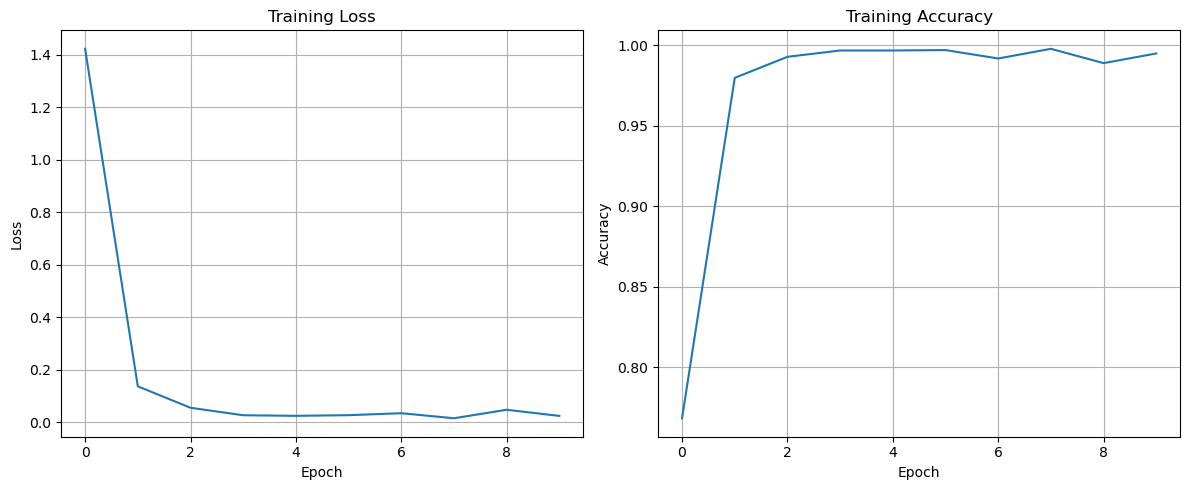

In [28]:
# === 绘图：Loss 和 Accuracy ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()